FFR 120  
Felix Waldschock

HW 2  
Exercise 7.6

In [676]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
from tqdm import trange


In [677]:
# Simulation parameters
L = 100                                     # length of the box
sigma = 1       
dT = .01
dT = .01

N = 10                                     # number of trajectiories (particles)
T_tot = [100000]                             # total time
T_tot = np.array(T_tot)
Iteration_Steps = T_tot * (1 / dT)          # total number of steps 
max_steps = int(np.max(Iteration_Steps))    # maximum number of steps


# parameters
n_drift = 50
n_diff = 5


x0 = 0          # initial position of the particle
alpha = 1
sigma0 = 1
dSigma = 1.8 

numberOfIntervalls = 50
Lk = L / numberOfIntervalls
IntervallCenters = np.linspace(0, (numberOfIntervalls-1)*Lk, numberOfIntervalls) + Lk/2 - L/2


In [678]:
def getDrift(displacement):
    displacement = np.mean(displacement, axis=0)
    return displacement / (n_drift * dT)

In [679]:
def getDiff(displacement):
    displacement = np.mean(displacement, axis=0)
    return (displacement**2) / (2 * n_diff * dT)

In [680]:
# constant noise simulation ex 7.2, create a trajectory matrix containing trajectories of all particles

def simulate_trajectory_constant(N, max_steps, L):
    x = np.zeros(N)*x0
    
    trajectories = np.zeros((N, len(T_tot)))                             # array to store trajectories  
    sigmas_ = np.zeros(N)                                                # array to store sigmas
        
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        # calc new sigma
        o = sigma * np.sqrt(dT)
        directions = np.random.choice([-1, 1], N)
        x += directions * o
        
        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)
        
        trajectoryTensor[:,s] = x
    
    trajectories[:, -1] = x
    sigmas_[:] = sigma

    
    return trajectories, sigmas_, trajectoryTensor

In [681]:
# multiplicative noise 
def simulate_trajectory_multiplicative(N, max_steps, L, alpha):
    x = np.ones(N)*x0

    trajectories = np.zeros((N, len(T_tot)))                            # array to store trajectories  
    sigmas_ = np.zeros(N)                                               # array to store sigmas
 
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        
        # get new noise
        sigma = np.zeros(N)
        # multiplicative noise
        tmp1 = sigma0 + dSigma*x/L
        tmp2 = dSigma * dT / L
        tmp3 = tmp1 * np.sqrt(dT)
        direction = np.random.choice([-1,1], N)
        sigma = alpha * tmp1 * tmp2 + tmp3 * direction
        
        x += sigma

        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)

        trajectoryTensor[:,s] = x
    
        if s in Iteration_Steps:
            index = np.where(Iteration_Steps == s)[0][0]
            trajectories[:, index] = x

    trajectories[:, -1] = x
    sigmas_ = sigma

    return trajectories, sigmas_, trajectoryTensor


In [682]:
# Run constant simulation
trajectories_constant, sigmas_constant, trajectoryTensor_constant = simulate_trajectory_constant(N, max_steps, L)


100%|██████████| 10000000/10000000 [01:58<00:00, 84295.18it/s]


In [683]:
# Run multiplicative simulation
trajectories_multiplicative, sigmas_multiplicative, trajectoryTensor_multiplicative = simulate_trajectory_multiplicative(N, max_steps, L, alpha)

100%|██████████| 10000000/10000000 [03:06<00:00, 53696.72it/s]


In [684]:
def computeDriftDiff(trajectoryTensor, name):
    # if a particle is in an intervall, check where it is after n_drift steps, use this difference to getDrift
    drift = np.zeros(numberOfIntervalls)
    driftCounter = np.ones(numberOfIntervalls)
    diff = np.zeros(numberOfIntervalls)
    diffCounter = np.ones(numberOfIntervalls)

    # trajecoryTensor comes in dimension (N, max_steps)
    numP = trajectoryTensor.shape[0]
    numSteps = trajectoryTensor.shape[1]

    # loop over all particles
    for t in trange(numP):
        # loop over all time steps
            for s in range(numSteps-n_drift-1):
                currentParticle = trajectoryTensor[t, s]
                # check from which intervallCenter the particle lays < Lk/2 away
                intervallIndex = np.where(np.abs(currentParticle - IntervallCenters) <= Lk/2)[0][0]
                #print(intervallIndex)
                # check where the particle is after n_drift steps and add to drift array, increment counter
                driftDifference = trajectoryTensor[t,s+n_drift] - currentParticle
                diffDifference = trajectoryTensor[t,s+n_diff] - currentParticle


                drift[intervallIndex] += driftDifference
                driftCounter[intervallIndex] += 1
                diff[intervallIndex] += diffDifference
                diffCounter[intervallIndex] += 1


    # save diff and diffCounter
    np.save("diff_"+name+".npy", diff)
    np.save("diffCounter_"+name+".npy", diffCounter)

    # implement the formulas 7.13 / 7.14

    # 7.13
    drift = drift/driftCounter
    drift = drift/(dT * n_drift)

    # square the delta of diffusions
    diff = diff**2 
    # take average
    diff = diff/diffCounter

    diff = diff/(dT * n_diff *2)

    #print(driftCounter)

    if np.isnan(drift).all():
        print("drift nan")

    # print(drift)

    # if nan set to zero  
    drift[np.isnan(drift)] = 0
    diff[np.isnan(diff)] = 0

    return drift, driftCounter, diff, diffCounter

In [685]:
# compute the drift and diffusion for both simulation trajectories
if(1):
    drift_constant, driftCounter_const, diffusion_constant, diffCounter_const = computeDriftDiff(trajectoryTensor_constant,"const")



 70%|███████   | 7/10 [02:48<01:12, 24.02s/it]

In [ ]:
if(1):
    drift_multiplicative, driftCounter_mult, diffusion_multiplicative, diffCounter_mult = computeDriftDiff(trajectoryTensor_multiplicative,"mult")


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


In [ ]:
def lowPassFilter(array, tau):
    # simple low pass filter to smooth the data
    # tau is the time constant
    # array is the array to be smoothed
    # returns the smoothed array


    # bypass
    if(1):
        return array

    smoothedArray = np.zeros(len(array))
    smoothedArray[0] = array[0]
    for i in range(1, len(array)):
        smoothedArray[i] = smoothedArray[i-1] + (array[i] - smoothedArray[i-1]) * dT / tau
    return smoothedArray

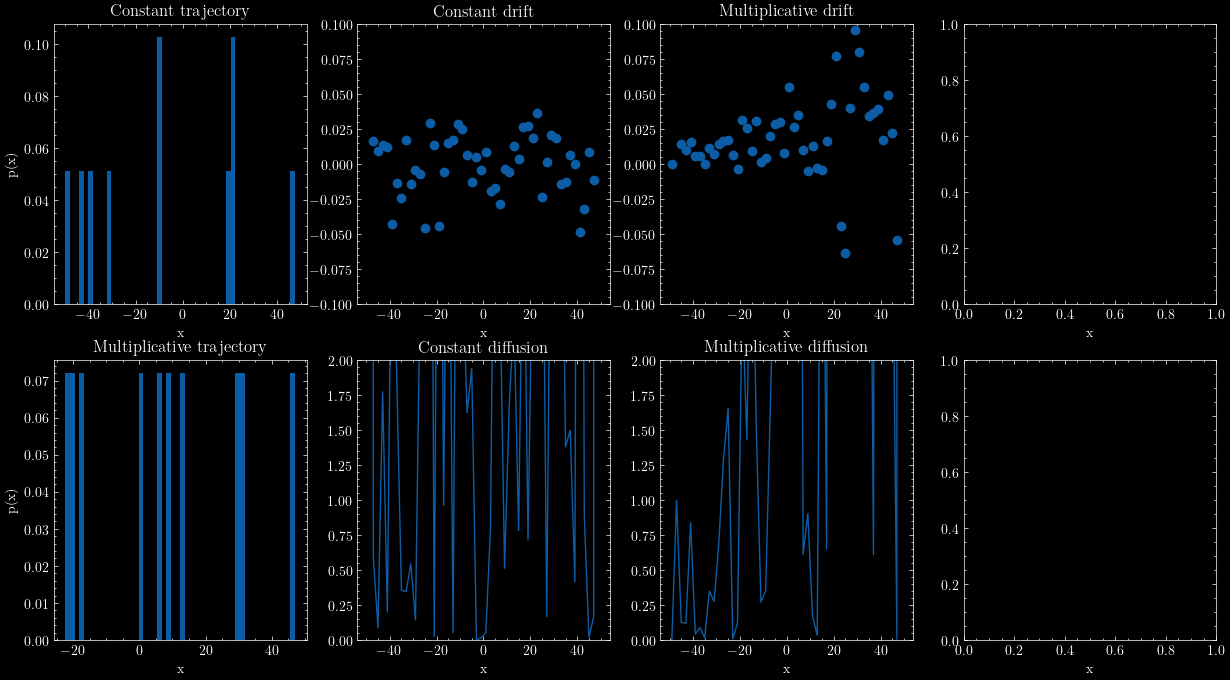

In [ ]:
# plot a 2x3 subplot
fig, axs = plt.subplots(2, 4, figsize=(15,8))
x_init = np.linspace(-L/2, L/2, N)

# plot the constantDrift and conStantDiffusion in 1 and 2
axs[0, 0].hist(trajectories_constant, bins=50, density=True, label='constant drift')
#axs[0, 0].plot(x_init, trajectories_constant[0,:], label='constant drift')
axs[0, 0].set_title('Constant trajectory')
axs[0, 0].set(ylabel='p(x)')

axs[1, 0].hist(trajectories_multiplicative, bins=50, density=True, label='multiplicative trajectory')
axs[1, 0].set_title('Multiplicative trajectory')
axs[1, 0].set(ylabel='p(x)')

axs[0, 1].plot(IntervallCenters,drift_constant, 'o',label='constant noise')
axs[0, 1].set_title('Constant drift')
axs[0, 1].set_ylim(-0.1, 0.1)

axs[1, 1].plot(IntervallCenters,lowPassFilter(diffusion_constant,4*dT), label='constant noise')
axs[1, 1].set_title('Constant diffusion')
axs[1, 1].set_ylim(-0, 2)


axs[0, 2].plot(IntervallCenters,drift_multiplicative, 'o', label='multiplicative noise')
axs[0, 2].set_title('Multiplicative drift')
axs[0, 2].set_ylim(-0.1, 0.1)


axs[1, 2].plot(IntervallCenters,lowPassFilter(diffusion_multiplicative, 4*dT), label='multiplicative noise')
axs[1, 2].set_title('Multiplicative diffusion')
axs[1, 2].set_ylim(-0, 2)


# set x label for all plots "x"
for ax in axs.flat:
    ax.set(xlabel='x')

The trend of the diffusion looks good, but I am very sure that a problem with too little sampling data is given. 

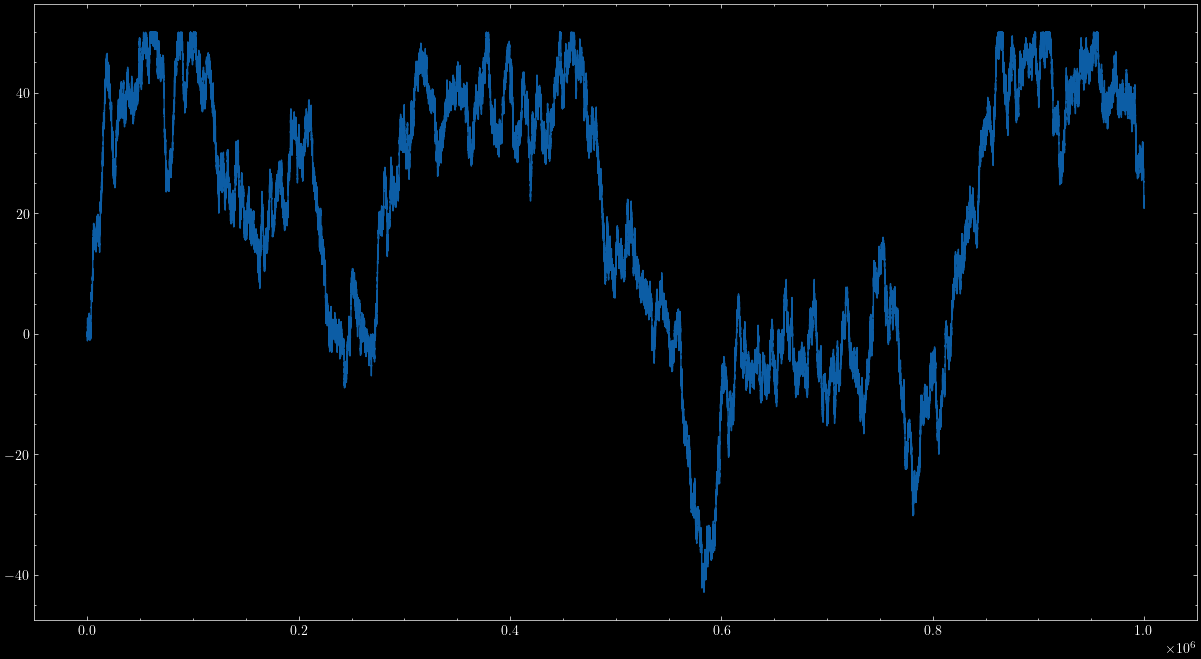

In [ ]:
# plot the trajectory of the constant noise simulation
fig = plt.figure(figsize=(15,8))
plt.plot(trajectoryTensor_constant[0,:], label='constant noise')
plt.show()

In [ ]:
a = np.array([1,2,np.nan])

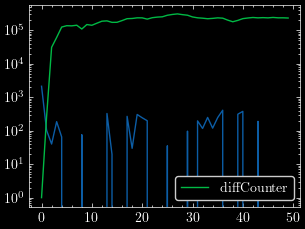

<function matplotlib.pyplot.show(close=None, block=None)>

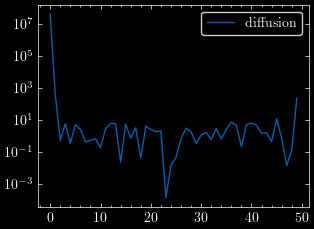

In [ ]:
diff = np.load("diff_const.npy")
diffCounter = np.load("diffCounter_mult.npy")

plt.semilogy(diff)
plt.plot(diffCounter, label="diffCounter")
plt.legend()
plt.show()
plt.semilogy((diff**2)/(diffCounter*dT * 2 * n_diff), label="diffusion")
plt.legend()
plt.show



100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]

(50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


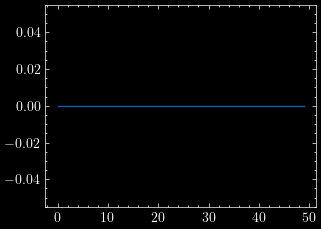

In [ ]:
# artificial trajectory

t = np.array([[-0,1,2,1,2,3,1,2,9,4,5,6,1,2,3,4,5]])
#get drift and diff
drift, driftCounter, diff, diffCounter = computeDriftDiff(t,"artificial")

print(drift.shape)
print(diff)
plt.plot(diff)

(0.0, 2.0)

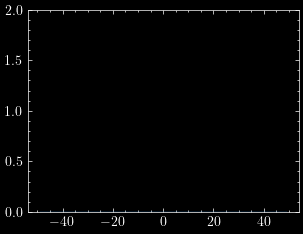

In [ ]:
# load artificial drift and diff
diff = np.load("diff_artificial.npy")
diffCounter = np.load("diffCounter_artificial.npy")
# plt.plot(diff)
# plt.plot(diff/diffCounter)
# plt.plot(diff**2)
# plt.plot((diff**2)/(diffCounter))
plt.plot(IntervallCenters,(diff**2)/(diffCounter* 2 * n_diff))
plt.ylim(0, 2)